In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 31.7 MB/s 
     |████████████████████████████████| 596 kB 66.6 MB/s 
     |████████████████████████████████| 6.6 MB 57.0 MB/s 
     |████████████████████████████████| 86 kB 6.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
import torch
from transformers import BertModel, BertTokenizer

In [3]:
tokenizer = BertTokenizer.from_pretrained('ltgoslo/norbert')
bert = BertModel.from_pretrained('ltgoslo/norbert', output_hidden_states = True)

token_embedding = {token: bert.get_input_embeddings()(torch.tensor(id))  for token, id in tokenizer.get_vocab().items()}

Downloading:   0%|          | 0.00/255k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/113 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/382 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/427M [00:00<?, ?B/s]

Some weights of the model checkpoint at ltgoslo/norbert were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
# Put the model in "evaluation" mode, meaning feed-forward operation.
bert.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(32922, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [5]:
def bert_text_preparation(text, tokenizer):
    """Preparing the input for BERT
    
    Takes a string argument and performs
    pre-processing like adding special tokens,
    tokenization, tokens to ids, and tokens to
    segment ids. All tokens are mapped to seg-
    ment id = 1.
    
    Args:
        text (str): Text to be converted
        tokenizer (obj): Tokenizer object
            to convert text into BERT-re-
            adable tokens and ids
        
    Returns:
        list: List of BERT-readable tokens
        obj: Torch tensor with token ids
        obj: Torch tensor segment ids
    
    
    """
    marked_text = "[CLS] " + text + " [SEP]"
    tokenized_text = tokenizer.tokenize(marked_text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    segments_ids = [1]*len(indexed_tokens)

    # Convert inputs to PyTorch tensors
    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])

    return tokenized_text, tokens_tensor, segments_tensors

In [30]:
def get_bert_embeddings(tokens_tensor, segments_tensors, model):
    """Get embeddings from an embedding model
    
    Args:
        tokens_tensor (obj): Torch tensor size [n_tokens]
            with token ids for each token in text
        segments_tensors (obj): Torch tensor size [n_tokens]
            with segment ids for each token in text
        model (obj): Embedding model to generate embeddings
            from token and segment ids
    
    Returns:
        list: List of list of floats of size
            [n_tokens, n_embedding_dimensions]
            containing embeddings for each token
    
    """
    
    # Gradient calculation id disabled
    # Model is in inference mode
    with torch.no_grad():
        outputs = model(tokens_tensor, segments_tensors)
        # Removing the first hidden state
        # The first state is the input state
        hidden_states = outputs[2]

    token_embeddings = torch.stack(hidden_states, dim=0)



    token_embeddings = torch.squeeze(token_embeddings, dim=1)

    token_embeddings = token_embeddings.permute(1,0,2)

    token_vecs_cat = []
    for token in token_embeddings:
    
      # `token` is a [12 x 768] tensor

      # Concatenate the vectors (that is, append them together) from the last 
      # four layers.
      # Each layer vector is 768 values, so `cat_vec` is length 3,072.
      # cat_vec = torch.cat((token[-1], token[-2], token[-3], token[-4]), dim=0)
      cat_vec = torch.sum(token[-4:], dim=0)
      
      # Use `cat_vec` to represent `token`.
      token_vecs_cat.append(cat_vec)
      
    return token_vecs_cat

In [7]:
import pandas as pd
from tqdm.auto import tqdm
import re

In [8]:
data = pd.read_csv('corpus-all_synsets.csv')

In [9]:
def gold_synset(df):
  
  gold_k = []
  for ind, row in tqdm(df.iterrows()):
    nums_target = re.findall(r'\d+', row.targets)
    nums_syns = re.findall(r'\d+', row.sense_key)
    gold_k.append(nums_syns[int(nums_target[0])])

  return gold_k

In [10]:
data['gold_keys'] = gold_synset(data)

0it [00:00, ?it/s]

In [11]:
data

,id,sentence,sense_key,lemma,targets,gold_keys
0,d0000.s0000.t0000,[TGT] Lam [TGT] og piggvar på bryllupsmenyen |,"['59170', '46605', '46604']",lam,[0],59170
1,d0000.s0000.t0001,Lam og [TGT] piggvar [TGT] på bryllupsmenyen |,['64474'],piggvar,[0],64474
2,d0000.s0000.t0002,Lam og piggvar på [TGT] bryllupsmenyen [TGT] |,['21858'],bryllups+meny,[0],21858
3,d0000.s0001.t0000,"Kamskjell , [TGT] piggvar [TGT] og lammefilet ...",['64474'],piggvar,[0],64474
4,d0000.s0001.t0001,"Kamskjell , piggvar og [TGT] lammefilet [TGT] ...",['2341'],lammefilet,[0],2341
...,...,...,...,...,...,...
4945,d0000.s3093.t0001,"Jeg registrerer at Johnsen denne gangen , som ...",['14637'],fornøyd,[0],14637
4946,d0000.s3094.t0000,"Hvis det kan blidgjøre Jan Johnsen , skal jeg ...","['8328', '7303', '8580', '19964', '28637']",virke,[0],8328
4947,d0000.s3094.t0001,"Hvis det kan blidgjøre Jan Johnsen , skal jeg ...",['16836'],nybil+salg,[0],16836
4948,d0000.s3095.t0000,Men det var ikke antall solgte nybiler som var...,"['590', '496', '26177', '12541', '38459']",rest,[0],590


In [12]:
import numpy as np

In [33]:
# Getting embeddings for the target
# word in all given contexts
target_word_embeddings = []


for ind, row in tqdm(data.iterrows()):
    text = row.sentence
    trgt_word = re.search(r'\[TGT\](.*)\[TGT\]', text).group(1)
    tokens_word = tokenizer.tokenize(trgt_word)
    tokenized_text, tokens_tensor, segments_tensors = bert_text_preparation(text, tokenizer)
    list_token_embeddings = get_bert_embeddings(tokens_tensor, segments_tensors, bert)
    
    if len(tokens_word) == 1:

      word_index = tokenized_text.index(tokens_word[0])
      word_embedding = list_token_embeddings[word_index]
    
    else:

      subwords_vector = []
      for tkn in tokens_word:
        subword_index = tokenized_text.index(tkn)
        subword_embedding = list_token_embeddings[subword_index].numpy()
        subwords_vector.append(subword_embedding)
      
      word_embedding = torch.from_numpy(np.mean(subwords_vector, axis = 0, keepdims = True))

      
    target_word_embeddings.append(word_embedding)

0it [00:00, ?it/s]

In [34]:
target_word_embeddings[0].shape

torch.Size([768])

In [35]:
def get_bert_embeddings_sent(tokens_tensor, segments_tensors, model, ):
    with torch.no_grad():
        outputs = model(tokens_tensor, segments_tensors)
        hidden_states = outputs[2] 

    sentence_embedding = torch.mean(hidden_states[-2][0], dim=0)
    return sentence_embedding

In [36]:
tokenized_text, tokens_tensor, segments_tensors = bert_text_preparation('Lam og piggvar på [TGT] bryllupsmenyen [TGT]', tokenizer)
get_bert_embeddings_sent(tokens_tensor, segments_tensors, bert).shape

torch.Size([768])

In [40]:
len(data.gold_keys.unique())

1462

In [41]:
embeddings_senses = {}

unique_golds = data.gold_keys.unique().tolist()



for gold in tqdm(unique_golds):
  subset = data[data.gold_keys == gold]

  gold_emb_all = []
  for ind, row in subset.iterrows():
    text = row.sentence
    tokenized_text, tokens_tensor, segments_tensors = bert_text_preparation(text, tokenizer)
    loc_emb = get_bert_embeddings_sent(tokens_tensor, segments_tensors, bert).numpy()
    gold_emb_all.append(loc_emb)

  word_embedding = torch.from_numpy(np.mean(gold_emb_all, axis = 0, keepdims = True))

  embeddings_senses[gold] = word_embedding

  0%|          | 0/1462 [00:00<?, ?it/s]

In [ ]:
embeddings_senses

### Baseline

In [44]:
all_senses = []

for ind, row in data.iterrows():
  all_senses.append(eval(row.sense_key))

data.sense_key = all_senses

In [49]:
data['word_emb'] = target_word_embeddings

In [50]:
data

,id,sentence,sense_key,lemma,targets,gold_keys,word_emb
0,d0000.s0000.t0000,[TGT] Lam [TGT] og piggvar på bryllupsmenyen |,"[59170, 46605, 46604]",lam,[0],59170,"[tensor(-1.6366), tensor(-2.5931), tensor(-4.1..."
1,d0000.s0000.t0001,Lam og [TGT] piggvar [TGT] på bryllupsmenyen |,[64474],piggvar,[0],64474,"[[tensor(-3.4815), tensor(-0.6453), tensor(0.6..."
2,d0000.s0000.t0002,Lam og piggvar på [TGT] bryllupsmenyen [TGT] |,[21858],bryllups+meny,[0],21858,"[[tensor(1.8969), tensor(0.2703), tensor(-5.55..."
3,d0000.s0001.t0000,"Kamskjell , [TGT] piggvar [TGT] og lammefilet ...",[64474],piggvar,[0],64474,"[[tensor(-5.8332), tensor(0.0334), tensor(-1.5..."
4,d0000.s0001.t0001,"Kamskjell , piggvar og [TGT] lammefilet [TGT] ...",[2341],lammefilet,[0],2341,"[[tensor(-1.8473), tensor(-4.6120), tensor(-5...."
...,...,...,...,...,...,...,...
4945,d0000.s3093.t0001,"Jeg registrerer at Johnsen denne gangen , som ...",[14637],fornøyd,[0],14637,"[tensor(0.2598), tensor(-6.6627), tensor(-4.41..."
4946,d0000.s3094.t0000,"Hvis det kan blidgjøre Jan Johnsen , skal jeg ...","[8328, 7303, 8580, 19964, 28637]",virke,[0],8328,"[tensor(-1.6421), tensor(1.5781), tensor(-5.00..."
4947,d0000.s3094.t0001,"Hvis det kan blidgjøre Jan Johnsen , skal jeg ...",[16836],nybil+salg,[0],16836,"[[tensor(1.2762), tensor(1.8189), tensor(-1.71..."
4948,d0000.s3095.t0000,Men det var ikke antall solgte nybiler som var...,"[590, 496, 26177, 12541, 38459]",rest,[0],590,"[tensor(-3.1376), tensor(-1.7677), tensor(-3.8..."


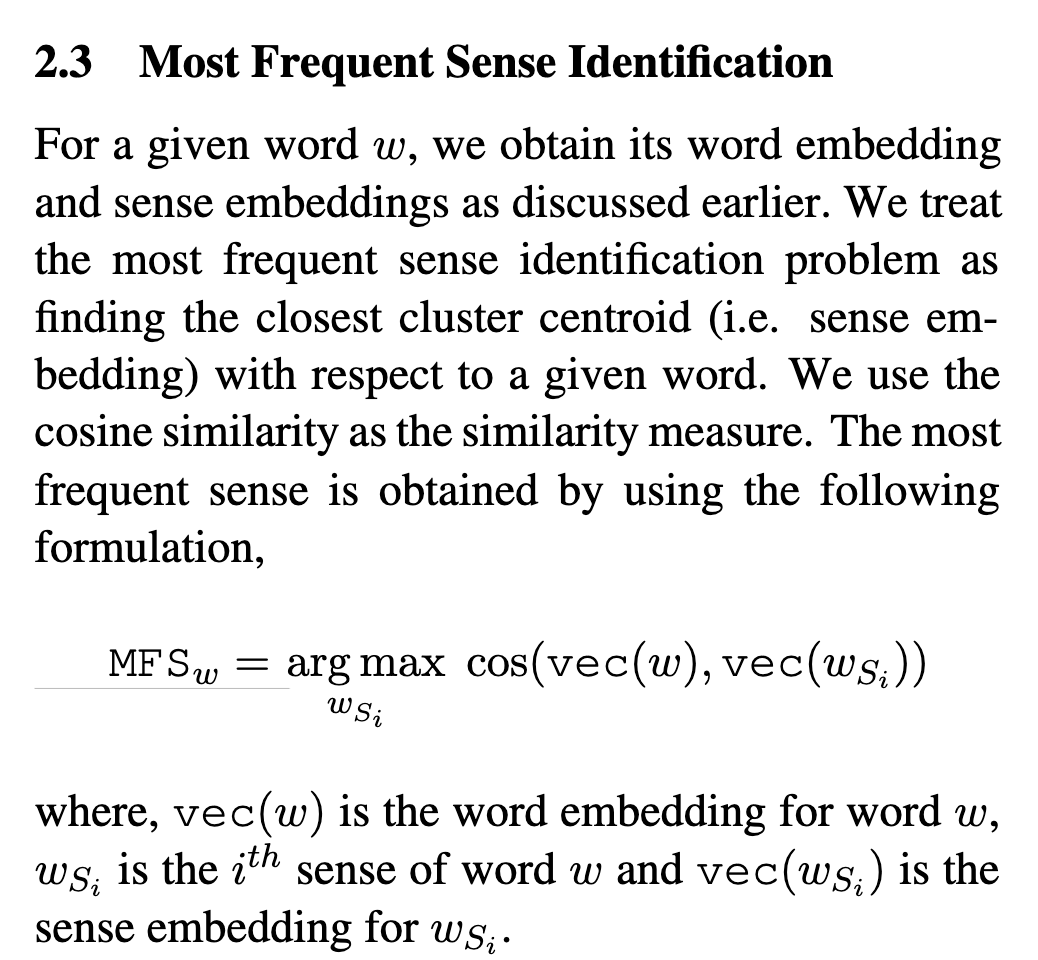

In [51]:
from scipy.spatial.distance import cosine

In [56]:
s = set( val for val in embeddings_senses.keys())

In [59]:
len(s)

1462

In [65]:
list_predictions = []

for ind, row in tqdm(data.iterrows()):
  emb_word = row['word_emb']
  all_syns = row.sense_key

  list_mfa = []
  try:
    for sense in all_syns:
      emb_sense = embeddings_senses[sense]
      list_mfa.append(cosine(emb_word, emb_sense))
  except:
      list_mfa.append(0.01)

  list_predictions.append(all_syns[np.argmax(list_mfa)])

0it [00:00, ?it/s]

In [66]:
data['predicted'] = list_predictions

In [67]:
data

,id,sentence,sense_key,lemma,targets,gold_keys,word_emb,predicted
0,d0000.s0000.t0000,[TGT] Lam [TGT] og piggvar på bryllupsmenyen |,"[59170, 46605, 46604]",lam,[0],59170,"[tensor(-1.6366), tensor(-2.5931), tensor(-4.1...",59170
1,d0000.s0000.t0001,Lam og [TGT] piggvar [TGT] på bryllupsmenyen |,[64474],piggvar,[0],64474,"[[tensor(-3.4815), tensor(-0.6453), tensor(0.6...",64474
2,d0000.s0000.t0002,Lam og piggvar på [TGT] bryllupsmenyen [TGT] |,[21858],bryllups+meny,[0],21858,"[[tensor(1.8969), tensor(0.2703), tensor(-5.55...",21858
3,d0000.s0001.t0000,"Kamskjell , [TGT] piggvar [TGT] og lammefilet ...",[64474],piggvar,[0],64474,"[[tensor(-5.8332), tensor(0.0334), tensor(-1.5...",64474
4,d0000.s0001.t0001,"Kamskjell , piggvar og [TGT] lammefilet [TGT] ...",[2341],lammefilet,[0],2341,"[[tensor(-1.8473), tensor(-4.6120), tensor(-5....",2341
...,...,...,...,...,...,...,...,...
4945,d0000.s3093.t0001,"Jeg registrerer at Johnsen denne gangen , som ...",[14637],fornøyd,[0],14637,"[tensor(0.2598), tensor(-6.6627), tensor(-4.41...",14637
4946,d0000.s3094.t0000,"Hvis det kan blidgjøre Jan Johnsen , skal jeg ...","[8328, 7303, 8580, 19964, 28637]",virke,[0],8328,"[tensor(-1.6421), tensor(1.5781), tensor(-5.00...",19964
4947,d0000.s3094.t0001,"Hvis det kan blidgjøre Jan Johnsen , skal jeg ...",[16836],nybil+salg,[0],16836,"[[tensor(1.2762), tensor(1.8189), tensor(-1.71...",16836
4948,d0000.s3095.t0000,Men det var ikke antall solgte nybiler som var...,"[590, 496, 26177, 12541, 38459]",rest,[0],590,"[tensor(-3.1376), tensor(-1.7677), tensor(-3.8...",496


In [68]:
from sklearn.metrics import f1_score

In [69]:
y_true = data['gold_keys']
y_pred = data['predicted']

In [70]:
f1_score(y_true, y_pred, average='macro')

0.3035171724656353

In [71]:
f1_score(y_true, y_pred, average='micro')

0.46646464646464647

In [72]:
f1_score(y_true, y_pred, average='weighted')

0.5197269130989843